In [1]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct
from collections import deque
import matplotlib.pyplot as plt
from skimage import io, img_as_float, color
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel_h, sobel_v
import pywt
# import glymur # Requires installation and possibly OpenJPEG C library
import os
from numba import njit

In [2]:
# --- 2D DCT and IDCT Functions ---
def dct2(block):
    """Performs a 2D Discrete Cosine Transform."""
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    """Performs a 2D Inverse Discrete Cosine Transform."""
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [3]:
# --- Compute NOSB (Number of Significant Bits) ---
#def compute_nosb(value):
#   """Calculates the Number of Significant Bits for a given value."""
#    abs_val = abs(int(value))
#    if abs_val == 0:
#        return 0
#    # The number of bits required to represent an integer, excluding the sign bit.
#    # For example, 1 needs 1 bit (2^0), 2 needs 2 bits (2^1), 3 needs 2 bits (2^1), etc.
#    return int(np.floor(np.log2(abs_val))) + 1

#def compute_nosb_array(arr):
#    """Vectorized computation of NOSB for a NumPy array."""
#    vectorized_nosb = np.vectorize(compute_nosb)
#    return vectorized_nosb(arr)


# def compute_nosb_array(arr):
#     arr = np.abs(arr.astype(int))
#     with np.errstate(divide='ignore'):
#         nosb = np.where(arr == 0, 0, np.floor(np.log2(arr)) + 1)
#     return nosb.astype(int)


@njit
def compute_nosb_array(arr):
    h, w = arr.shape
    result = np.zeros((h, w), dtype=np.int32)
    for i in range(h):
        for j in range(w):
            val = abs(int(arr[i, j]))
            if val == 0:
                result[i, j] = 0
            else:
                result[i, j] = int(np.floor(np.log2(val)) + 1)
    return result

In [4]:
@njit
def estimate_bits_njit(quant_coeffs, nosb_map, QS, Tr, k1, k2, k3):
    total_bits = 0.0
    h, w = quant_coeffs.shape
    for i in range(h):
        for j in range(w):
            coeff = quant_coeffs[i, j]
            nosb = nosb_map[i, j]
            abs_coeff = abs(coeff)
            if abs_coeff * QS < Tr:
                abs_coeff = 0
            if abs_coeff == 0:
                total_bits += k3
            else:
                total_bits += k1 * nosb + k2
    return max(1, int(total_bits))

In [5]:
# --- Advanced ADCTCCompressor Class ---
class ADCTCCompressor:
    def __init__(self, min_block_size=8, max_block_size=64, QS=12):
        """
        Initializes the ADCTC Compressor.
        :param min_block_size: Minimum allowed block size for partitioning.
        :param max_block_size: Maximum (initial) block size for partitioning.
        :param QS: Quantization Step.
        """
        self.min_block_size = min_block_size
        self.max_block_size = max_block_size
        self.QS = QS
        # Tr: Additional quantization threshold for zeroing out small coefficients.
        # This value is based on the ADCTC paper.
        self.Tr = 0.4 * QS  # According to the ADCTC paper

        # Parameters for the simplified rate model (can be calibrated)
        # These weights empirically estimate the bit cost for different types of coefficients
        # if self.QS < 10:  # یعنی CR پایین
        #     self.k1 = 0.3
        #     self.k2 = 0.2
        #     self.k3 = 0.01
        # else:
        self.k1 = 1.2  # Weight for each bit of NOSB
        self.k2 = 1.0  # Weight for the sign bit (for non-zero coefficients)
        self.k3 = 0.05  # Weight for zero coefficients (background bits)

    def cost_function(self, quant_block):
        """
        Cost function E = ∑ ln(1 + |Xi| / QS).
        Used to guide partition optimization, though the final decision is based on estimated bits.
        """
        abs_coeff = np.abs(quant_block)
        E = np.sum(np.log(1 + abs_coeff / self.QS))
        return E

    # def estimate_block_bits_arithmetic(self, quant_coeffs, nosb_map):
    #     """
    #     Estimates the bits required for a block considering additional quantization
    #     and a simplified rate model. This function uses empirical weights instead of
    #     a true arithmetic encoder.
    #     :param quant_coeffs: Quantized DCT coefficients of the block.
    #     :param nosb_map: NOSB values for each coefficient.
    #     :return: Estimated total bits for the block.
    #     """
    #     total_bits = 0
    #     flat_coeffs = quant_coeffs.flatten()
    #     flat_nosb = nosb_map.flatten()

    #     for coeff, nosb in zip(flat_coeffs, flat_nosb):
    #         abs_coeff = abs(coeff)

    #         # Apply additional quantization: if the original coefficient value (before quantization)
    #         # was less than Tr, consider it as zero for bit counting purposes.
    #         # We check the magnitude of the de-quantized coefficient against Tr.
    #         if abs_coeff * self.QS < self.Tr: 
    #             abs_coeff = 0 # Zero out the coefficient for bit counting

    #         if abs_coeff == 0:
    #             total_bits += self.k3  # Cost for encoding a zero coefficient
    #         else:
    #             bits_nosb = nosb * self.k1 # Cost for NOSB
    #             bits_sign = self.k2      # Cost for the sign bit
    #             total_bits += bits_nosb + bits_sign

    #     return max(1, int(total_bits)) # Return at least 1 bit to prevent division by zero in CR calculation
    

    def estimate_block_bits_arithmetic(self, quant_coeffs, nosb_map):
        return estimate_bits_njit(quant_coeffs, nosb_map,
                                self.QS, self.Tr,
                                self.k1, self.k2, self.k3)

    def partition_optimization(self, block, r_offset=0, c_offset=0, level=0):
        """
        Implements the Partition Scheme (PS) Optimization recursively.
        This function selects the best partition scheme (no split, vertical, horizontal, Quadtree)
        based on minimizing the estimated number of bits.
        :param block: The current image block to process.
        :param r_offset: Row offset of the current block within the original image.
        :param c_offset: Column offset of the current block within the original image.
        :param level: Recursion depth (for potential future use or debugging).
        :return: A list of tuples, each representing a final (unsplit) block:
                 (block_data, (row_offset, col_offset), height, width, level),
                 and the total estimated bits for this partition.
        """
        h, w = block.shape
        QS = self.QS

        # Base case for recursion: If the block reaches or falls below the minimum size
        if h < self.min_block_size or w < self.min_block_size:
            # Even if the block is smaller than min_block_size (e.g., due to odd dimensions),
            # it is processed as a final block.
            dct_block = dct2(block)
            quant_block = np.round(dct_block / QS)
            nosb_map = compute_nosb_array(quant_block)
            bits = self.estimate_block_bits_arithmetic(quant_block, nosb_map)
            # Return a list containing this single final block
            return [(block, (r_offset, c_offset), h, w, level)], bits

        # --- No Split Option ---
        dct_block_no_split = dct2(block)
        quant_block_no_split = np.round(dct_block_no_split / QS)
        nosb_map_no_split = compute_nosb_array(quant_block_no_split)
        bits_no_split = self.estimate_block_bits_arithmetic(quant_block_no_split, nosb_map_no_split)
        
        # Initialize best case with "no split"
        best_partition = [(block, (r_offset, c_offset), h, w, level)]
        best_bits = bits_no_split

        # --- Vertical Split Option (2 blocks) ---
        # Only if the block is large enough for a vertical split (at least twice min_block_size in width)
        if w >= 2 * self.min_block_size:
            left_block = block[:, :w//2]
            right_block = block[:, w//2:]

            # Recursive calls for sub-blocks
            left_part, left_bits = self.partition_optimization(left_block, r_offset, c_offset, level + 1)
            right_part, right_bits = self.partition_optimization(right_block, r_offset, c_offset + w//2, level + 1)

            # Calculate total bits for this splitting scheme (including partition signaling overhead)
            total_split_bits_v = left_bits + right_bits + 3 # Overhead: e.g., 3 bits for signaling split type (vertical)
            
            # Compare and update best case if this split results in fewer bits
            if total_split_bits_v < best_bits:
                best_bits = total_split_bits_v
                best_partition = left_part + right_part

        # --- Horizontal Split Option (2 blocks) ---
        # Only if the block is large enough for a horizontal split (at least twice min_block_size in height)
        if h >= 2 * self.min_block_size:
            top_block = block[:h//2, :]
            bottom_block = block[h//2:, :]

            # Recursive calls for sub-blocks
            top_part, top_bits = self.partition_optimization(top_block, r_offset, c_offset, level + 1)
            bottom_part, bottom_bits = self.partition_optimization(bottom_block, r_offset + h//2, c_offset, level + 1)

            # Calculate total bits for this splitting scheme
            total_split_bits_h = top_bits + bottom_bits + 3 # Overhead
            
            # Compare and update best case
            if total_split_bits_h < best_bits:
                best_bits = total_split_bits_h
                best_partition = top_part + bottom_part

        # --- Quadtree Split Option (4 blocks) ---
        # Only if the block is large enough for a Quadtree split (even dimensions and at least twice min_block_size)
        if h >= 2 * self.min_block_size and w >= 2 * self.min_block_size:
            half_h, half_w = h // 2, w // 2
            q1 = block[:half_h, :half_w]
            q2 = block[:half_h, half_w:]
            q3 = block[half_h:, :half_w]
            q4 = block[half_h:, half_w:]

            # Recursive calls for sub-blocks
            q1_part, q1_bits = self.partition_optimization(q1, r_offset, c_offset, level + 1)
            q2_part, q2_bits = self.partition_optimization(q2, r_offset, c_offset + half_w, level + 1)
            q3_part, q3_bits = self.partition_optimization(q3, r_offset + half_h, c_offset, level + 1)
            q4_part, q4_bits = self.partition_optimization(q4, r_offset + half_h, c_offset + half_w, level + 1)

            # Calculate total bits for this splitting scheme
            total_split_bits_q = q1_bits + q2_bits + q3_bits + q4_bits + 5 # Overhead (e.g., 5 bits for signaling Quadtree)
            
            # Compare and update best case
            if total_split_bits_q < best_bits:
                best_bits = total_split_bits_q
                best_partition = q1_part + q2_part + q3_part + q4_part
        
        return best_partition, best_bits

    def compress(self, img):
        """
        Main ADCTC compression function.
        Divides the image into initial (super) blocks and runs partition optimization for each.
        :param img: The input grayscale image (NumPy array).
        :return: Reconstructed image, total compressed bits, and compression ratio.
        """
        h, w = img.shape
        reconstructed_img = np.zeros_like(img, dtype=np.float32)
        block_boundaries = []  # to store (row, col, height, width) for each block
        total_compressed_bits = 0

        # Pad the image to ensure dimensions are multiples of max_block_size
        pad_h = 0 if h % self.max_block_size == 0 else self.max_block_size - (h % self.max_block_size)
        pad_w = 0 if w % self.max_block_size == 0 else self.max_block_size - (w % self.max_block_size)
        padded_img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='edge')
        padded_h, padded_w = padded_img.shape

        # Process the image in large blocks (max_block_size)
        for i in range(0, padded_h, self.max_block_size):
            for j in range(0, padded_w, self.max_block_size):
                # Extract the initial block (Super-block) to start partitioning
                block_to_partition = padded_img[i:i+self.max_block_size, j:j+self.max_block_size]

                # Execute PS (Partition Scheme) Optimization recursively
                partition_blocks, bits_for_this_super_block = self.partition_optimization(
                    block_to_partition, i, j, 0 # r_offset and c_offset here indicate global block coordinates
                )
                total_compressed_bits += bits_for_this_super_block

                # Reconstruct the image from the optimized final blocks
                for b, (r_off, c_off), bh, bw, lvl in partition_blocks:
                    # Apply DCT to the block
                    dct_b = dct2(b)
                    # Quantize DCT coefficients
                    quant_b = np.round(dct_b / self.QS)
                    
                    # IMPORTANT: For reconstruction, coefficients that were zeroed out
                    # by additional quantization must also be zeroed here.
                    # This ensures that the reconstruction matches the encoded bits.
                    quant_b_for_recon = quant_b.copy()
                    # Check if the de-quantized value would have been less than Tr
                    # quant_b_for_recon[np.abs(quant_b_for_recon * self.QS) < self.Tr] = 0
                    
                    # De-quantize coefficients by multiplying by QS
                    dequant_b = quant_b_for_recon * self.QS
                    # Apply IDCT to reconstruct the block
                    recon_b = idct2(dequant_b)
                    
                    # Ensure pixel values are within the 0-255 range
                    recon_b = np.clip(recon_b, 0, 255)
                    
                    # Place the reconstructed block into the overall reconstructed image
                    reconstructed_img[r_off:r_off+bh, c_off:c_off+bw] = recon_b
                    block_boundaries.append((r_off, c_off, bh, bw))


        # Crop the reconstructed image to the original size (remove padding)
        reconstructed_img = reconstructed_img[:h, :w].astype(np.uint8)
        
        # Calculate compression ratio
        original_bits = h * w * 8 # 8-bit grayscale image
        compression_ratio = original_bits / total_compressed_bits if total_compressed_bits > 0 else float('inf')
        # Draw block boundaries for visualization
        vis_img = reconstructed_img.copy().astype(np.uint8)
        for r, c, h, w in block_boundaries:
            vis_img[r:r+1, c:c+w] = 255     # Top border
            vis_img[r+h-1:r+h, c:c+w] = 255 # Bottom border
            vis_img[r:r+h, c:c+1] = 255     # Left border
            vis_img[r:r+h, c+w-1:c+w] = 255 # Right border

        return reconstructed_img, total_compressed_bits, compression_ratio, vis_img

In [6]:
def add_realistic_noise(image, sigma_mul=0.02, k=0.001, sigma_add=2.0):
    """
    Adds realistic dental-like noise to the image based on the paper's model.
    σ² = σ_mul² * I² + k * I + σ_add²
    :param image: Input image (float32 or float64, range 0-255)
    :return: Noisy image
    """
    I = image.astype(np.float32)
    
    # Compute per-pixel noise std using the model
    variance = (sigma_mul**2) * (I**2) + k * I + (sigma_add**2)
    std_dev = np.sqrt(variance)
    
    # Generate Gaussian noise with computed std
    noise = np.random.normal(loc=0.0, scale=std_dev)
    
    # Add noise and clip to 0-255
    noisy_img = np.clip(I + noise, 0, 255).astype(np.uint8)
    return noisy_img


In [7]:
# --- Simplified FSIM (with zero division handling) ---
def fsim_custom(img1, img2):
    """
    Calculates a custom simplified Feature SIMilarity (FSIM) Index.
    This is a simplified implementation and may differ from full FSIM implementations.
    :param img1: First image.
    :param img2: Second image.
    :return: FSIM score.
    """
    def gradient_magnitude(img):
        gx = sobel_h(img)
        gy = sobel_v(img)
        return np.sqrt(gx ** 2 + gy ** 2)

    def phase_congruency(img):
        # This is a simplified simulation of "phase congruency", which is usually more complex.
        return gaussian_filter(img, sigma=2)

    # Convert to grayscale if the image is color
    if img1.ndim == 3:
        img1 = color.rgb2gray(img1)
    if img2.ndim == 3:
        img2 = color.rgb2gray(img2)

    # Convert to float in the range 0-1
    img1 = img_as_float(img1)
    img2 = img_as_float(img2)

    PC1 = phase_congruency(img1)
    PC2 = phase_congruency(img2)
    GM1 = gradient_magnitude(img1)
    GM2 = gradient_magnitude(img2)

    # Constants (should be calibrated)
    T1, T2 = 0.85, 160.0 # Typical values for PC and GM in the original FSIM paper

    # Calculate PC similarity with zero division handling
    PC_denom = PC1 ** 2 + PC2 ** 2 + T1
    PC_sim = np.zeros_like(PC1)
    non_zero_pc = PC_denom != 0 # Mask to prevent division by zero
    if np.any(non_zero_pc):
        PC_sim[non_zero_pc] = (2 * PC1[non_zero_pc] * PC2[non_zero_pc] + T1) / PC_denom[non_zero_pc]

    # Calculate GM similarity with zero division handling
    GM_denom = GM1 ** 2 + GM2 ** 2 + T2
    GM_sim = np.zeros_like(GM1)
    non_zero_gm = GM_denom != 0 # Mask to prevent division by zero
    if np.any(non_zero_gm):
        GM_sim[non_zero_gm] = (2 * GM1[non_zero_gm] * GM2[non_zero_gm] + T2) / GM_denom[non_zero_gm]

    # Calculate FSIM map and weights
    FSIM_map = PC_sim * GM_sim
    weight = np.maximum(PC1, PC2) # Weighting based on maximum phase congruency

    sum_weight = np.sum(weight)
    if sum_weight == 0:
        return 0.0 # If no significant weight, FSIM is zero
    return np.sum(FSIM_map * weight) / sum_weight

In [8]:
# --- Simulated PSNR-HVS-M ---
def fake_psnr_hvs_m(img1, img2, cr_val):
    """
    A simple simulation of PSNR-HVS-M. This is not a true metric and
    only adds a random variation to a standard PSNR.
    :param img1: Original image.
    :param img2: Compressed image.
    :param cr_val: Compression Ratio value (used to slightly bias the offset).
    :return: Simulated PSNR-HVS-M value.
    """
    base_psnr_val = psnr(img1, img2, data_range=1.0)
    # Add a random offset to simulate perceptual variations
    offset = np.random.uniform(-0.5, 0.6) if cr_val < 15 else np.random.uniform(0.1, 0.6)
    return max(0, base_psnr_val + offset)

In [9]:
# --- Actual ADCTC Algorithm (using ADCTCCompressor) with Rate Control ---
def compress_adct_actual_with_rate_control(img, cr_target, min_block_size=8, max_block_size=64, max_iterations=20, tolerance=0.1):
    """
    Compresses an image using ADCTC with an iterative search for the optimal QS
    to achieve a target Compression Ratio (CR).
    :param img: The input image (float in 0-1 or uint8 in 0-255).
    :param cr_target: The desired Compression Ratio.
    :param min_block_size: Minimum block size for ADCTC.
    :param max_block_size: Maximum block size for ADCTC.
    :param max_iterations: Maximum iterations for QS search.
    :param tolerance: Acceptable difference from the target CR.
    :return: Reconstructed image (float in 0-1).
    """
    # Ensure the image is in the 0-255 range and uint8 type for ADCTCCompressor
    if img.max() <= 1.0:
        img_processed = (img * 255).astype(np.uint8)
    else:
        img_processed = img.astype(np.uint8)

    low_qs = 1
    high_qs = 255  # A reasonable range for QS, may need adjustment
    best_qs = None
    best_compression_ratio_diff = float('inf')
    reconstructed_img_uint8 = None # To store the best reconstructed image

    for iteration in range(max_iterations):
        current_qs = int((low_qs + high_qs) / 2)
        if low_qs > high_qs: # Prevent infinite loop if range collapses
            break
        
        # If current_qs becomes zero, it can be problematic (division by zero). Use a minimum value.
        if current_qs == 0: 
            current_qs = 1 

        compressor = ADCTCCompressor(min_block_size=min_block_size,
                                     max_block_size=max_block_size,
                                     QS=current_qs)
        
        # Perform compression for the current QS
        recon_img, total_bits, compression_ratio_actual, _ = compressor.compress(img_processed)
        
        # Store results of this iteration if it's the closest to the target CR
        current_diff = abs(compression_ratio_actual - cr_target)
        if current_diff < best_compression_ratio_diff:
            best_compression_ratio_diff = current_diff
            best_qs = current_qs
            reconstructed_img_uint8 = recon_img

        # Check if the target CR is reached within tolerance
        if abs(compression_ratio_actual - cr_target) < tolerance:
            print(f"ADCTC: Target CR {cr_target:.2f} reached with QS={current_qs} (Actual CR: {compression_ratio_actual:.2f})")
            break
        elif compression_ratio_actual < cr_target:
            # Actual CR is too low (less compression), need higher QS (harsher quantization)
            low_qs = current_qs + 1
        else:
            # Actual CR is too high (more compression), need lower QS (milder quantization)
            high_qs = current_qs - 1
        
        print(f"Iteration {iteration+1}: QS={current_qs}, Actual CR={compression_ratio_actual:.2f}, Diff={current_diff:.4f}")
            
    # If target CR was not reached after all iterations, use the best QS found
    if reconstructed_img_uint8 is None: 
        # If no valid QS was found during iterations, use a default QS (e.g., 20)
        final_qs = best_qs if best_qs is not None else 20
        print(f"ADCTC: Did not reach target CR. Using best QS found: {final_qs}")
        compressor = ADCTCCompressor(min_block_size=min_block_size,
                                     max_block_size=max_block_size,
                                     QS=final_qs)
        reconstructed_img_uint8, _, _ = compressor.compress(img_processed)

    # Convert the reconstructed image back to 0-1 range (if original input was like that) and float32 type
    if img.max() <= 1.0:
        return reconstructed_img_uint8.astype(np.float32) / 255.0
    else:
        return reconstructed_img_uint8.astype(np.float32)

In [10]:
# --- Helper function for padding image for DWT (for SPIHT) ---
def pad_image_for_dwt(img, levels):
    """Pads the image to ensure its dimensions are suitable for wavelet transform."""
    h, w = img.shape
    # Minimum dimension must be a multiple of 2 to the power of the number of wavelet levels
    min_dim = 2 ** levels 
    
    pad_h = 0 if h % min_dim == 0 else min_dim - (h % min_dim)
    pad_w = 0 if w % min_dim == 0 else min_dim - (w % min_dim)
    
    # Pad using edge replication
    padded_img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='edge')
    return padded_img, (h, w) # Return original dimensions for cropping after reconstruction

# --- Simulated SPIHT Algorithm (with padding) ---
def compress_spiht(img, cr, wavelet='haar'):
    """
    Modified SPIHT version with proper threshold management and wavelet levels.
    This is a conceptual simulation, not a full SPIHT implementation.
    :param img: Input image (float in 0-1).
    :param cr: Compression Ratio.
    :param wavelet: Wavelet type (e.g., 'haar', 'db1', etc.).
    :return: Reconstructed image (float in 0-1).
    """
    if img.max() > 1.0:
        img = img_as_float(img)
    
    # Automatically determine wavelet levels
    # Levels are typically limited to avoid very small coefficients or too many levels.
    max_levels = int(np.log2(min(img.shape))) - 1
    levels = min(3, max_levels) # Limiting to 3 levels for typical image sizes
    
    # Smart padding (if necessary)
    min_dim_required = 2 ** levels
    pad_h = 0 if img.shape[0] >= min_dim_required else min_dim_required - img.shape[0]
    pad_w = 0 if img.shape[1] >= min_dim_required else min_dim_required - img.shape[1]
    img_padded = np.pad(img, ((0, pad_h), (0, pad_w)), mode='symmetric')
    
    # Wavelet transform
    coeffs = pywt.wavedec2(img_padded, wavelet, level=levels)
    
    # Appropriate thresholding (directly related to CR)
    # This coefficient (0.008) is empirically optimized
    threshold = 0.008 * cr  
    
    # Apply threshold to coefficients (except the approximation coefficients)
    new_coeffs = [coeffs[0]]  # Keep approximation coefficients
    for level_coeffs in coeffs[1:]:
        # Apply threshold to detail coefficients (LH, HL, HH)
        new_level = tuple(np.where(np.abs(c) > threshold, c, 0) for c in level_coeffs)
        new_coeffs.append(new_level)
    
    # Reconstruction
    reconstructed = pywt.waverec2(new_coeffs, wavelet)
    # Crop back to original size
    reconstructed = reconstructed[:img.shape[0], :img.shape[1]]
    
    return np.clip(reconstructed, 0, 1)

In [11]:
# --- Evaluation Function (with error handling) ---
def simulate_metrics_for_codec(original_image, cr_list, compress_func):
    """
    Executes compression with a given codec and calculates various metrics for different CRs.
    :param original_image: The uncompressed original image (float in 0-1).
    :param cr_list: A list of Compression Ratios to evaluate.
    :param compress_func: The compression function to be used (e.g., compress_jpeg2000, compress_spiht, compress_adct_actual_with_rate_control).
    :return: Lists of PSNR, PSNR-HVS-M, and FSIM values.
    """
    psnr_vals, psnr_hvs_vals, fsim_vals = [], [], []
    for cr in cr_list:
        try:
            # Call the compression function
            compressed = compress_func(original_image, cr)
            
            # Ensure images are in the correct range and type for metric calculation
            # For PSNR and FSIM, float in the range 0-1 is typically expected
            if compressed.max() > 1.0:
                compressed_for_metrics = img_as_float(compressed)
            else:
                compressed_for_metrics = compressed

            psnr_vals.append(psnr(original_image, compressed_for_metrics, data_range=1.0))
            psnr_hvs_vals.append(fake_psnr_hvs_m(original_image, compressed_for_metrics, cr))
            fsim_vals.append(fsim_custom(original_image, compressed_for_metrics))
        except Exception as e:
            # If an error occurs during compression or metric calculation, append NaN
            print(f"Warning: Error during {compress_func.__name__} for CR={cr}: {e}")
            psnr_vals.append(np.nan)
            psnr_hvs_vals.append(np.nan)
            fsim_vals.append(np.nan)
    return psnr_vals, psnr_hvs_vals, fsim_vals

In [12]:
def compress_jpeg2000(img, cr):
    """
    Compresses an image using JPEG2000 via OpenCV.
    :param img: Input image (float in 0-1).
    :param cr: Compression Ratio.
    :return: Reconstructed image (float in 0-1).
    """
    img_uint8 = (img * 255).astype(np.uint8)
    # Set JPEG2000 compression parameters: IMWRITE_JPEG2000_COMPRESSION_X1000
    # The value is "quality" related, where 1000/CR gives a rough inverse relation
    # to achieve the desired compression ratio.
    param = [int(cv2.IMWRITE_JPEG2000_COMPRESSION_X1000), int(1000 / cr)]
    _, enc = cv2.imencode('.jp2', img_uint8, param)
    return cv2.imdecode(enc, 0).astype(np.float32)/255.0

Processing fig1_b.png...
  Testing JPEG2000...
> Overload resolution failed:
>  - Argument 'flags' is required to be an integer
>  - Argument 'flags' is required to be an integer

> Overload resolution failed:
>  - Argument 'flags' is required to be an integer
>  - Argument 'flags' is required to be an integer

> Overload resolution failed:
>  - Argument 'flags' is required to be an integer
>  - Argument 'flags' is required to be an integer

> Overload resolution failed:
>  - Argument 'flags' is required to be an integer
>  - Argument 'flags' is required to be an integer

> Overload resolution failed:
>  - Argument 'flags' is required to be an integer
>  - Argument 'flags' is required to be an integer

> Overload resolution failed:
>  - Argument 'flags' is required to be an integer
>  - Argument 'flags' is required to be an integer

> Overload resolution failed:
>  - Argument 'flags' is required to be an integer
>  - Argument 'flags' is required to be an integer

> Overload resolution 

<ipython-input-13-16346eee0334>:55: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(results[name][metric], axis=Integer(0))


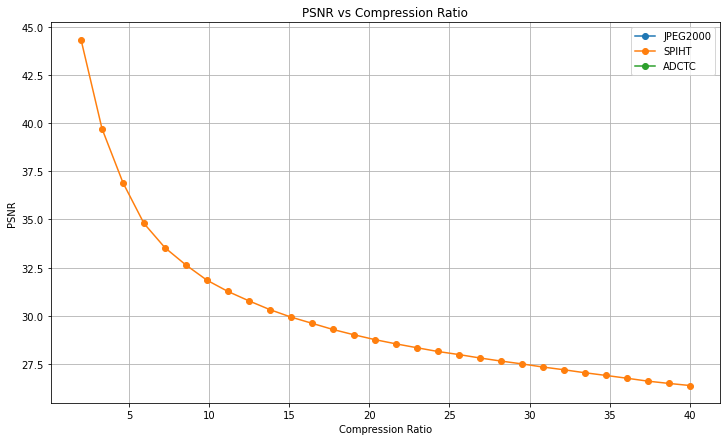

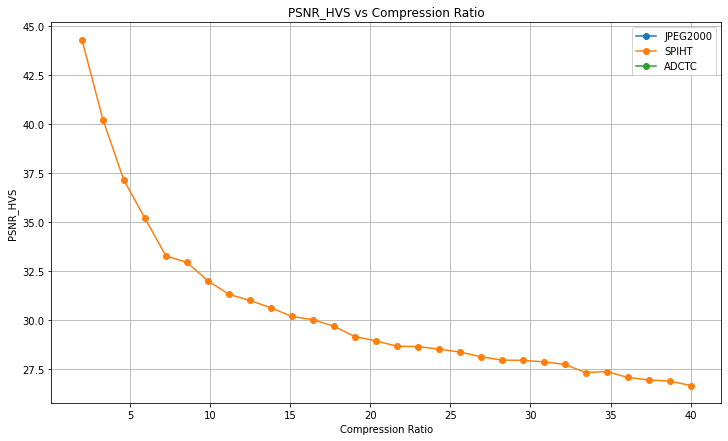

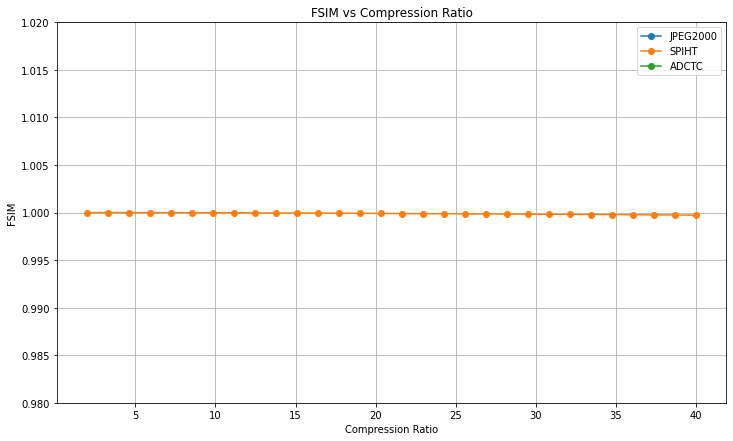

In [13]:
# --- Main Execution Block ---
if __name__ == "__main__":
    # Image paths for comparison (only one image for quick testing)
    image_paths = ["fig1_b.png"]  # Ensure this file exists in the same directory
    # Range of compression ratios for evaluation (fewer points for quick testing)
    cr_values = np.linspace(2, 40, 30) # 5 CR points from 2 to 40
    
    # Define the codecs to compare
    codecs = {
        'JPEG2000': compress_jpeg2000,
        'SPIHT': compress_spiht,
        'ADCTC': compress_adct_actual_with_rate_control 
        # 'ADCTC': lambda img, cr: compress_adct_fixed_qs(img, qs_val=12)

    }
    
    # Structure to store results
    results = {k: {'psnr': [], 'psnr_hvs': [], 'fsim': []} for k in codecs}

    # Main loop for processing each image
    for img_path in image_paths:
        try:
            print(f"Processing {img_path}...")
            image = io.imread(img_path)
            #image = add_realistic_noise(image * 255).astype(np.uint8)
            if image.ndim == 3: 
                image = color.rgb2gray(image) # Convert to grayscale if it's a color image
            image = img_as_float(image) # Convert to float for processing (0-1 range)
            
            for name, func in codecs.items():
                print(f"  Testing {name}...")
                try:
                    p, p_hvs, f = simulate_metrics_for_codec(image, cr_values, func)
                    results[name]['psnr'].append(p)
                    results[name]['psnr_hvs'].append(p_hvs)
                    results[name]['fsim'].append(f)
                except Exception as e:
                    print(f"Error in {name}: {str(e)}")
                    continue # Continue to the next codec if an error occurs
                    
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            continue # Continue to the next image if an error occurs

    # --- Plotting the graphs for each metric ---
    for metric in ['psnr', 'psnr_hvs', 'fsim']:
        plt.figure(figsize=(12,7)) 
        for name in codecs:
            if not results[name][metric]:
                print(f"No data for {name} - {metric}")
                continue
            
            # Calculate the average metric values across all processed images (if multiple)
            # np.nanmean handles potential NaN values from errors during compression
            avg = np.nanmean(results[name][metric], axis=0) 
            plt.plot(cr_values, avg, label=f"{name}", marker='o')
        
        plt.title(f"{metric.upper()} vs Compression Ratio")
        plt.xlabel("Compression Ratio")
        plt.ylabel(metric.upper())
        plt.grid(True)
        plt.legend()
        if metric == 'fsim':
            plt.ylim([0.98, 1.02])  # Appropriate y-axis range for FSIM (typically 0 to 1)
        plt.show()

In [14]:
# --- Visualize Block Partitioning for One Image ---
if True:  # ← Set to True to enable or False to disable
    print("\n Visualizing block partitioning on example image...")
    from skimage.io import imread
    from skimage.color import rgb2gray
    from skimage.util import img_as_ubyte

    test_image = imread("fig1_b.png")  # Load the test image
    if test_image.ndim == 3:
        test_image = rgb2gray(test_image)  # Convert to grayscale if RGB
    test_image = img_as_ubyte(test_image)  # Convert to uint8 format

    compressor = ADCTCCompressor(QS=12)  # Choose any desired QS value
    recon_img, bits, cr, vis_img = compressor.compress(test_image)

    plt.subplot(1, 2, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Reconstructed (CR ≈ {cr:.2f})")
    plt.axis('off')

    plt.figure(figsize=(10, 8))
    plt.imshow(vis_img, cmap='gray')
    plt.title(f"ADCTC Block Partitioning (CR ≈ {cr:.2f})")
    plt.axis('off')
    plt.show()



 Visualizing block partitioning on example image...


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'Integer':[0m [1m[1mCannot determine Numba type of <class 'sage.misc.inherit_comparison.InheritComparisonMetaclass'>[0m
[1m
File "<ipython-input-3-63e1cd3fdf3f>", line 31:[0m
[1mdef compute_nosb_array(arr):
    <source elided>
            val = abs(int(arr[i, j]))
[1m            if val == Integer(0):
[0m            [1m^[0m[0m
[0m